In [1]:
# Import everything! 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import time
import argopy
import gsw

Importing data...
Time to create DataFetcher variable :  0.0064487457275390625
Time to get data from DataFetcher :  3.9168319702148438
[2.0000e-01 8.0000e-01 1.7000e+00 ... 1.9381e+03 1.9628e+03 1.9875e+03]


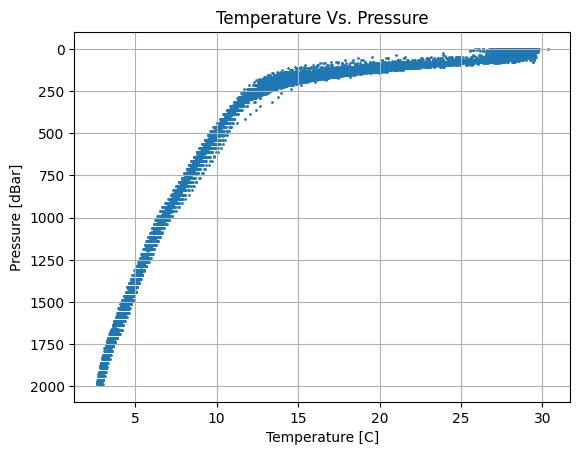

True

In [4]:
# Gabe's code to get data, save in csv, and plot temp
def plot_temp_vs_depth():
    try:
        df_raw = pd.read_csv('data.csv')
    except:
        print("Importing data...")
        t0 = time.time()
        lat_range = [5, 20]     # Latitude: 5°N to 20°N
        lon_range = [80, 95]   # Longitude: 80°E to 95°E
        # ArgoSet = argopy.DataFetcher().region([80, 95, 5, 20, 0, 2000, '2023-12', '2024-03'])
        ArgoSet = argopy.DataFetcher().region([lon_range[0], lon_range[1], lat_range[0], lat_range[1], 0, 2000, '2023-12', '2024-03']) # Bay of Bengal
        print("Time to create DataFetcher variable : ", time.time() - t0)
        df_raw = ArgoSet.data.argo.point2profile().to_dataframe()
        print("Time to get data from DataFetcher : ", time.time() - t0)
        # df_raw.to_csv('data_test.csv')

    # Remove rows where temp is None
    df = df_raw.dropna(subset=['TEMP', 'PRES'])

    # Define the variables to work with:
    temp = np.array(df['TEMP'])
    pressure = np.array(df['PRES'])
    print(pressure)

    # Scatter data and add grid
    plt.scatter(temp, pressure, s=1)
    plt.grid(True)
    plt.gca().invert_yaxis()

    # Adding labels to the axes and title
    plt.xlabel('Temperature [C]')
    plt.ylabel('Pressure [dBar]')
    plt.title('Temperature Vs. Pressure')

    # plt.savefig('figures/temp_vs_depth.png')
    plt.show()

    return True

plot_temp_vs_depth()

In [3]:
def load_csv():
    # Load the data from the CSV file
    data = pd.read_csv('/Users/emilywong/Documents/Processing/sioc210_data_project/data_winter.csv')

    # Show the first few rows of the data to confirm it's loaded correctly
    print(data.head())
    return data

def filter_one_float(data):
    # Filter data for one specific float (e.g., PLATFORM_NUMBER 2902766)
    float_data = data[data['PLATFORM_NUMBER'] == 2902766]

    # Sort by pressure (depth) if needed
    float_data = float_data.sort_values(by='PRES')

    print(float_data.head())
    return float_data

In [4]:
# Calculate the means and stds of salinity, density (by first calculating density), and temp 
def calculate_mean_profiles(data):
    # Create arrays to store averaged values
    unique_depths = sorted(data['PRES'].unique())  # Get unique depths
    mean_salinity = []
    mean_density = []
    mean_temperature = []
    std_salinity = []
    std_density = []
    std_temperature = []
    filtered_depths = [] # To get rid of weird line
    
    # Loop over each depth, calculate mean and std for salinity, density, and temperature
    for depth in unique_depths:
        depth_data = data[data['PRES'] == depth]
        
        # Skip if depth_data is empty
        if depth_data.empty:
            # Append NaN values for missing data
            mean_salinity.append(np.nan)
            std_salinity.append(np.nan)
            mean_temperature.append(np.nan)
            std_temperature.append(np.nan)
            mean_density.append(np.nan)
            std_density.append(np.nan)
            filtered_depths.append(depth)
            continue
        
        # Salinity calculations
        mean_salinity.append(depth_data['PSAL'].mean())
        std_salinity.append(depth_data['PSAL'].std())
        
        # Temperature calculations
        mean_temperature.append(depth_data['TEMP'].mean())
        std_temperature.append(depth_data['TEMP'].std())
        
        # Density calculations (using gsw for in-situ density; should we be using potential instead?)
        # Uses same method as calculate_density function
        salinity = depth_data['PSAL'].values
        temperature = depth_data['TEMP'].values
        pressure = depth
        latitude = depth_data['LATITUDE'].iloc[0]  
        longitude = depth_data['LONGITUDE'].iloc[0]
        
        SA = gsw.SA_from_SP(salinity, pressure, longitude, latitude)
        CT = gsw.CT_from_t(SA, temperature, pressure)
        density = gsw.rho(SA, CT, pressure)
        
        mean_density.append(np.mean(density))
        std_density.append(np.std(density))
        
        # Only append the depth if all data was successfully calculated
        filtered_depths.append(depth)
    
    return filtered_depths, mean_salinity, std_salinity, mean_temperature, std_temperature, mean_density, std_density

In [6]:
def create_salinity_plot(float_data):

    # Plot Salinity vs Depth
    plt.figure(figsize=(8, 6))
    plt.plot(float_data['PSAL'], float_data['PRES'], label='Salinity')

    # Invert the y-axis so that the surface (shallow depths) is at the top
    plt.gca().invert_yaxis()

    # Label the axes
    plt.xlabel('Salinity [PSU]')
    plt.ylabel('Pressure [dbar]')

    # Add a title
    plt.title('Salinity Profile for Float 2902766')

    # Show the plot
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_avg_salinity(unique_depths, mean_salinity, std_salinity):
    # Plot average salinity values for entire range, with std

    plt.figure(figsize=(8, 6))
    plt.plot(mean_salinity, unique_depths, label='Mean Salinity')
    plt.fill_betweenx(unique_depths, 
                      np.array(mean_salinity) - np.array(std_salinity), 
                      np.array(mean_salinity) + np.array(std_salinity), 
                      color='b', alpha=0.2, label='Salinity Std Dev')

    # Invert axis to get surface at the top
    plt.gca().invert_yaxis()
    # Labels and title
    plt.xlabel('Salinity [PSU]')
    plt.ylabel('Pressure [dbar]')
    plt.title('Average Salinity Profile Across All Floats')
    plt.legend()
    plt.grid(True)
    plt.show()

In [7]:
def plot_avg_temperature(unique_depths, mean_temperature, std_temperature):
    # Plot temperature average over all data with std

    plt.figure(figsize=(8, 6))
    plt.plot(mean_temperature, unique_depths, label='Mean Temperature')
    plt.fill_betweenx(unique_depths, 
                      np.array(mean_temperature) - np.array(std_temperature), 
                      np.array(mean_temperature) + np.array(std_temperature), 
                      color='g', alpha=0.2, label='Temperature Std Dev')

    # Invert axis again to get surface at top
    plt.gca().invert_yaxis()
    # Labels and title
    plt.xlabel('Temperature [C]')
    plt.ylabel('Pressure [dbar]')
    plt.title('Average Temperature Profile Across All Floats')
    plt.legend()
    plt.grid(True)
    plt.show()

In [10]:
def calculate_density(float_data):
    # Calculate in-situ density using gsw 

    # Sort by pressure (depth)
    float_data = float_data.sort_values(by='PRES')

    # Calculate Absolute Salinity (SA) and Conservative Temperature (CT)
    # Note: gsw expects salinity in Practical Salinity Units (PSU), temperature in degrees Celsius, and pressure in decibars.
    pressure = float_data['PRES'].values
    salinity = float_data['PSAL'].values
    temperature = float_data['TEMP'].values
    latitude = float_data['LATITUDE'].values[0]  # Assuming constant latitude for the float
    longitude = float_data['LONGITUDE'].values[0]  # Assuming constant longitude for the float

    # Calculate Absolute Salinity and Conservative Temperature
    SA = gsw.SA_from_SP(salinity, pressure, longitude, latitude)
    CT = gsw.CT_from_t(SA, temperature, pressure)

    # Calculate density (in-situ density) using the equation of state
    density = gsw.rho(SA, CT, pressure)

    return pressure, density


def create_density_plot(float_data):
    # Create density plot for a single float 
    pressure, density = calculate_density(float_data)

    # Plot Density vs Depth
    plt.figure(figsize=(8, 6))
    plt.plot(density, pressure, label='Density')

    # Invert the y-axis so that the surface is at the top
    plt.gca().invert_yaxis()

    # Label the axes
    plt.xlabel('Density [kg/m^3]')
    plt.ylabel('Depth [dbar]')

    # Add a title
    plt.title('Density Profile for Float 2902766') # Have to change manually for different float 

    # Show the plot
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_avg_density(unique_depths, mean_density, std_density):
    # Plot average density for all floats, with std
    plt.figure(figsize=(8, 6))
    plt.plot(mean_density, unique_depths, label='Mean Density')
    plt.fill_betweenx(unique_depths, 
                      np.array(mean_density) - np.array(std_density), 
                      np.array(mean_density) + np.array(std_density), 
                      color='r', alpha=0.2, label='Density Std Dev')

    # Invert y-axis 
    plt.gca().invert_yaxis()
    # Labels and title
    plt.xlabel('Density [kg/m^3]')
    plt.ylabel('Pressure [dbar]')
    plt.title('Average Density Profile Across All Floats')
    plt.legend()
    plt.grid(True)
    plt.show()

   N_PROF  N_LEVELS  CYCLE_NUMBER DATA_MODE DIRECTION  PLATFORM_NUMBER  \
0      35         0           143         D         A          2902766   
1      35         1           143         D         A          2902766   
2      35         2           143         D         A          2902766   
3      35         3           143         D         A          2902766   
4      35         4           143         D         A          2902766   

   POSITION_QC  PRES  PRES_ERROR  PRES_QC      PSAL  PSAL_ERROR  PSAL_QC  \
0            1   0.2         2.4        1  32.42705        0.01        1   
1            1   0.8         2.4        1  32.42710        0.01        1   
2            1   1.7         2.4        1  32.42800        0.01        1   
3            1   2.5         2.4        1  32.42781        0.01        1   
4            1   3.5         2.4        1  32.43058        0.01        1   

     TEMP  TEMP_ERROR  TEMP_QC  TIME_QC  LATITUDE  LONGITUDE  \
0  28.656       0.002        1    

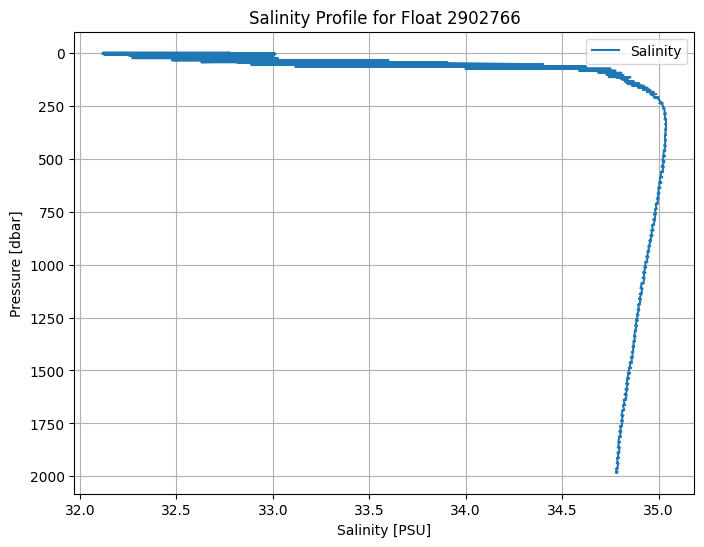

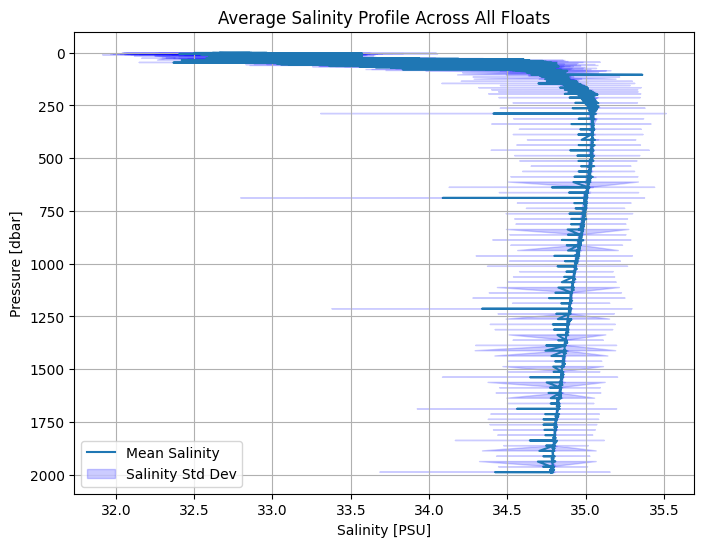

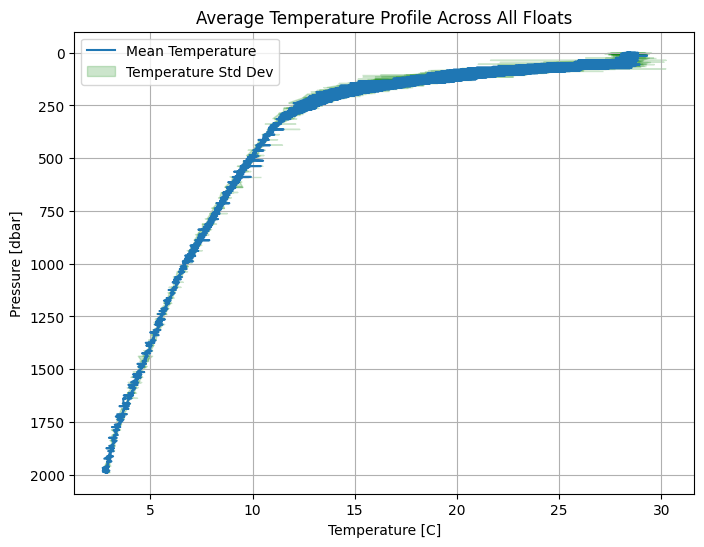

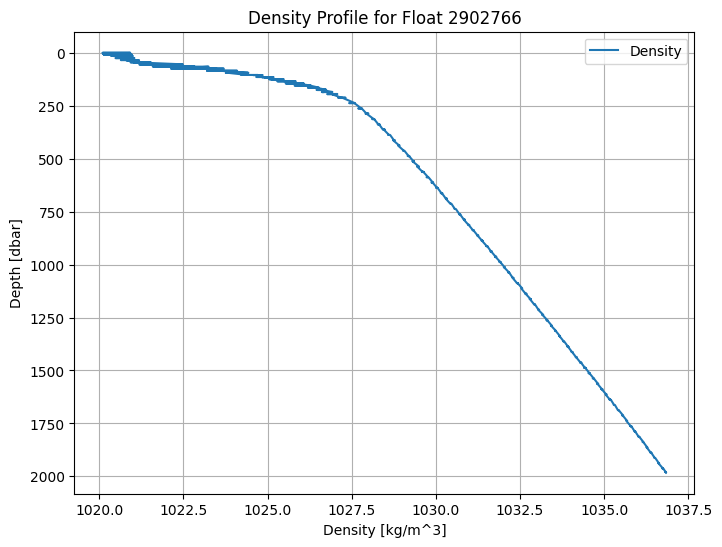

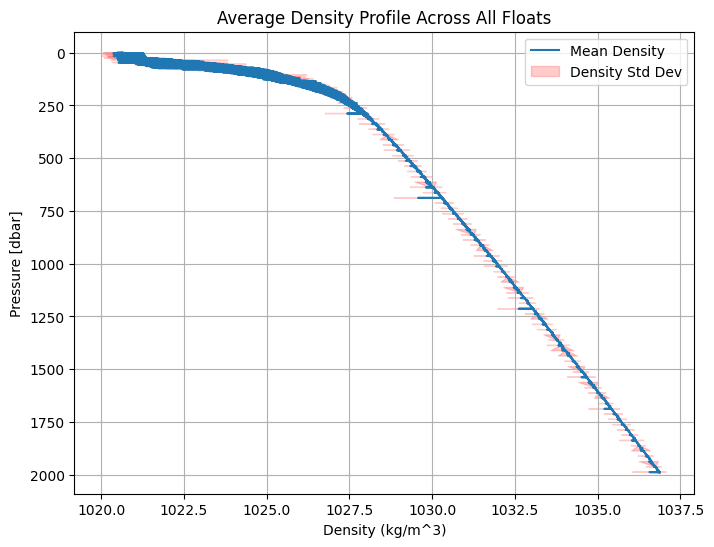

In [9]:
all_data = load_csv()
one_float_data = filter_one_float(all_data)

unique_depths, mean_salinity, std_salinity, mean_temperature, std_temperature, mean_density, std_density = calculate_mean_profiles(all_data)

create_salinity_plot(one_float_data)
plot_avg_salinity(unique_depths, mean_salinity, std_salinity)

# I didn't make a single plot for temp because Gabe's code had temp plot
plot_avg_temperature(unique_depths, mean_temperature, std_temperature)

create_density_plot(one_float_data)
plot_avg_density(unique_depths, mean_density, std_density)